In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

The following code generates the graph of each ontology and saves it in the ontology_graphs dictionary

In [16]:
import re

ONTOLOGIES = ['molecular_function', 'biological_process', 'cellular_component']

file_object  = open('../../gfpml-datasets/OBO/go-basic.obo', 'r') # OBO file
file_content = file_object.read()

ontology_graphs = {ontology: nx.DiGraph() for ontology in ONTOLOGIES}

for GO_info in re.findall('(?m)^id: GO:.*(?:\r?\n(?!\[(?:Typedef|Term)\]).*)*', file_content):
    if 'is_obsolete: true' in GO_info:
        continue
    data_GO = GO_info.split()
    ontology = data_GO[data_GO.index('namespace:') + 1]
    GO_id = data_GO[1]
    ontology_graphs[ontology].add_node(GO_id)
    is_a = [data_GO[idx + 1] for idx, x in enumerate(data_GO) if x == 'is_a:']
    for related_GO in is_a:
        ontology_graphs[ontology].add_edge(GO_id, related_GO)

file_object.close()

undirect_ontology_graphs = {ontology: graph.to_undirected() for ontology, graph in ontology_graphs.items()}

Predictions must be a dictionary of lists of GO terms and whose keys are genes ids.

In [7]:
def ancestors(ontology, y_pred):
    # y_pred are the GO terms predicted for a single gene
    # return the set of ancestors of GO terms in y_pred in the ontology
    ontology_graph = ontology_graphs[ontology]
    ans = set(y_pred)
    aux = set(y_pred)
    while len(aux) > 0:
        for node in aux:
            ans = ans.union(set(ontology_graph.successors(node)))
            aux = aux.union(set(ontology_graph.successors(node)))
            aux = aux - {node}
    return ans

def Hprecision_micro(ontology, Y_pred, Y_true):
    # Y_pred and Y_true are dictionaries whose keys are genes and values are lists of GO terms
    numerator = 0
    denominator = 0
    for gene, y_pred in Y_pred.items():
        y_true = Y_true[gene]
        P = ancestors(ontology, y_pred)
        T = ancestors(ontology, y_true)
        numerator += len(P.intersection(T))
        denominator += len(P)
    return numerator / denominator

def Hrecall_micro(ontology, Y_pred, Y_true):
    # Y_pred and Y_true are dictionaries whose keys are genes and values are lists of GO terms
    numerator = 0
    denominator = 0
    for gene, y_pred in Y_pred.items():
        y_true = Y_true[gene]
        P = ancestors(ontology, y_pred)
        T = ancestors(ontology, y_true)
        numerator += len(P.intersection(T))
        denominator += len(T)
    return numerator / denominator

def Hprecision_macro(ontology, Y_pred, Y_true):
    # Y_pred and Y_true are dictionaries whose keys are genes and values are lists of GO terms
    value = 0
    for gene, y_pred in Y_pred.items():
        y_true = Y_true[gene]
        P = ancestors(ontology, y_pred)
        T = ancestors(ontology, y_true)
        value += len(P.intersection(T)) / len(P)
    return value / len(Y_pred)

def Hrecall_macro(ontology, Y_pred, Y_true):
    # Y_pred and Y_true are dictionaries whose keys are genes and values are lists of GO terms
    value = 0
    for gene, y_pred in Y_pred.items():
        y_true = Y_true[gene]
        P = ancestors(ontology, y_pred)
        T = ancestors(ontology, y_true)
        value += len(P.intersection(T)) / len(T)
    return value / len(Y_pred)

The same but vectorized

In [8]:
def pred_to_array(ontology, Y_pred):
    # Y_pred is a dictionary whose keys are genes and values are lists of GO terms
    # Genes is the sorted list of keys of Y_pred
    # ans is the binary array that indicates ancestors of GO terms predicted
    nodes_ontology = np.array(sorted(ontology_graphs[ontology].nodes()))
    Genes = sorted(Y_pred)
    ans = np.array([np.in1d(nodes_ontology, list(ancestors(ontology, y_pred)), assume_unique=True)
                    for (gene, y_pred) in sorted(Y_pred.items())])
    return Genes, ans

def Hprecision_micro_vec(graph, Y_pred, Y_true):
    Genes, P = pred_to_array(ontology, Y_pred)
    Genes, T = pred_to_array(ontology, Y_true)
    return np.sum(P * T) / np.sum(P)

def Hrecall_micro_vec(graph, Y_pred, Y_true):
    Genes, P = pred_to_array(ontology, Y_pred)
    Genes, T = pred_to_array(ontology, Y_true)
    return np.sum(P * T) / np.sum(T)

def Hprecision_macro_vec(graph, Y_pred, Y_true):
    Genes, P = pred_to_array(ontology, Y_pred)
    Genes, T = pred_to_array(ontology, Y_true)
    return np.mean(np.sum(P * T, axis=1) / np.sum(P, axis=1))

def Hrecall_macro_vec(graph, Y_pred, Y_true):
    Genes, P = pred_to_array(ontology, Y_pred)
    Genes, T = pred_to_array(ontology, Y_true)
    return np.mean(np.sum(P * T, axis=1) / np.sum(T, axis=1))

The same but with sparse matrices

In [9]:
from scipy.sparse import csr_matrix

def pred_to_sparce(ontology, Y_pred):
    # Y_pred is a dictionary whose keys are genes and values are lists of GO terms
    # Genes is the sorted list of keys of Y_pred
    # ans is the binary array that indicates ancestors of GO terms predicted
    nodes_ontology = np.array(sorted(ontology_graphs[ontology].nodes()))
    Genes = sorted(Y_pred)
    cols = []
    rows = []
    for i, (gene, y_pred) in enumerate(sorted(Y_pred.items())):
        ancestors_pred = list(ancestors(ontology, y_pred))
        cols.append(np.searchsorted(nodes_ontology, ancestors_pred))
        rows.append(np.repeat(i, len(ancestors_pred)))

    rows = np.hstack(rows)
    cols = np.hstack(cols)
    ans = csr_matrix((np.ones_like(rows, dtype=bool), (rows, cols)), shape=(len(Y_pred), len(nodes_ontology)))
    return Genes, ans

def Hprecision_micro_sparse(graph, Y_pred, Y_true):
    Genes, P = pred_to_sparce(ontology, Y_pred)
    Genes, T = pred_to_sparce(ontology, Y_true)
    return (P.multiply(T)).sum() / P.sum()

## Testing

P {'C', 'F', 'B', 'R'}
T {'C', 'R', 'E', 'B'}
hprec 0.6666666666666666
P {'R', 'D', 'B'}
T {'C', 'R', 'E', 'B'}
hrecall 0.3333333333333333


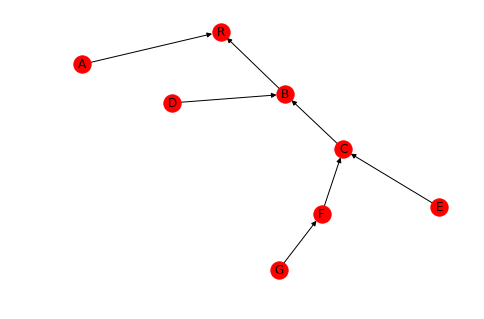

In [14]:
# Small example: https://idalab.de/blog/data-science/hierarchical-metrics

graph_example = nx.DiGraph()
graph_example.add_edge('A', 'R')
graph_example.add_edge('B', 'R')
graph_example.add_edge('D', 'B')
graph_example.add_edge('C', 'B')
graph_example.add_edge('F', 'C')
graph_example.add_edge('E', 'C')
graph_example.add_edge('G', 'F')

nodes_example = np.array(sorted(graph_example.nodes()))
nx.draw(graph_example, with_labels=True)

def ancestors_example(ontology, y_pred):
    ontology_graph = graph_example
    ans = set(y_pred)
    aux = set(y_pred)
    while len(aux) > 0:
        for node in aux:
            ans = ans.union(set(ontology_graph.successors(node)))
            aux = aux.union(set(ontology_graph.successors(node)))
            aux = aux - {node}
    return ans

def Hprecision_micro_example(ontology, Y_pred, Y_true):
    # Y_pred and Y_true are dictionaries whose keys are genes and values are lists of GO terms
    numerator = 0
    denominator = 0
    for gene, y_pred in Y_pred.items():
        y_true = Y_true[gene]
        P = ancestors_example(ontology, y_pred)
        T = ancestors_example(ontology, y_true)
        print('P', P)
        print('T', T)
        numerator += len(P.intersection(T))
        denominator += len(P)
    return (numerator - 1) / (denominator - 1)

def Hrecall_micro_example(ontology, Y_pred, Y_true):
    # Y_pred and Y_true are dictionaries whose keys are genes and values are lists of GO terms
    numerator = 0
    denominator = 0
    for gene, y_pred in Y_pred.items():
        y_true = Y_true[gene]
        P = ancestors_example(ontology, y_pred)
        T = ancestors_example(ontology, y_true)
        print('P', P)
        print('T', T)
        numerator += len(P.intersection(T))
        denominator += len(T)
    return (numerator - 1) / (denominator - 1)

ontology = ''

Y_pred = {'gene1': ['F']}
Y_true = {'gene1': ['E']}
print('hprec', Hprecision_micro_example(ontology, Y_pred, Y_true))

Y_pred = {'gene1': ['D']}
Y_true = {'gene1': ['E']}
print('hrecall', Hrecall_micro_example(ontology, Y_pred, Y_true))

In [120]:
ontology = 'biological_process'
nodes_ontology = np.array(sorted(ontology_graphs[ontology].nodes()))

N = len(nodes_ontology)

Y_pred = {'gene1': nodes_ontology[np.random.choice(N, 10)],
          'gene2': nodes_ontology[np.random.choice(N, 10)],
          'gene3': nodes_ontology[np.random.choice(N, 10)]}

Y_true = {'gene1': nodes_ontology[np.random.choice(N, 10)],
          'gene2': nodes_ontology[np.random.choice(N, 10)],
          'gene3': nodes_ontology[np.random.choice(N, 10)]}

print(Hprecision_micro(ontology, Y_pred, Y_true), Hprecision_micro_vec(ontology, Y_pred, Y_true), Hprecision_micro_sparse(ontology, Y_pred, Y_true))
print(Hprecision_macro(ontology, Y_pred, Y_true), Hprecision_macro_vec(ontology, Y_pred, Y_true))
print(Hrecall_micro(ontology, Y_pred, Y_true), Hrecall_micro_vec(ontology, Y_pred, Y_true))
print(Hrecall_macro(ontology, Y_pred, Y_true), Hrecall_macro_vec(ontology, Y_pred, Y_true))

import time

K = 10
M = 50

tic = time.clock()
for i in range(K):
    Y_pred = {'gene1': nodes_ontology[np.random.choice(N, M)],
              'gene2': nodes_ontology[np.random.choice(N, M)],
              'gene3': nodes_ontology[np.random.choice(N, M)]}

    Y_true = {'gene1': nodes_ontology[np.random.choice(N, M)],
              'gene2': nodes_ontology[np.random.choice(N, M)],
              'gene3': nodes_ontology[np.random.choice(N, M)]}
    Hprecision_micro(ontology, Y_pred, Y_true)
print('no vectorizada', time.clock() - tic)

tic = time.clock()
for i in range(K):
    Y_pred = {'gene1': nodes_ontology[np.random.choice(N, M)],
              'gene2': nodes_ontology[np.random.choice(N, M)],
              'gene3': nodes_ontology[np.random.choice(N, M)]}

    Y_true = {'gene1': nodes_ontology[np.random.choice(N, M)],
              'gene2': nodes_ontology[np.random.choice(N, M)],
              'gene3': nodes_ontology[np.random.choice(N, M)]}
    Hprecision_micro_vec(ontology, Y_pred, Y_true)
print('vectorizada', time.clock() - tic)

tic = time.clock()
for i in range(K):
    Y_pred = {'gene1': nodes_ontology[np.random.choice(N, M)],
              'gene2': nodes_ontology[np.random.choice(N, M)],
              'gene3': nodes_ontology[np.random.choice(N, M)]}

    Y_true = {'gene1': nodes_ontology[np.random.choice(N, M)],
              'gene2': nodes_ontology[np.random.choice(N, M)],
              'gene3': nodes_ontology[np.random.choice(N, M)]}
    Hprecision_micro_sparse(ontology, Y_pred, Y_true)
print('sparse', time.clock() - tic)

0.15544041450777202 0.15544041450777202 0.15544041450777202
0.15499343414601743 0.15499343414601743
0.17142857142857143 0.17142857142857143
0.17628383449737028 0.17628383449737028
no vectorizada 2.4892019999999917
vectorizada 5.536308000000005
sparse 5.111937999999995
